# Step 1. Getting the SEED dataset

## 1.1 load the matlab format files and take a look

In [1]:
import mne
from scipy import io
import os
import numpy as np

In [2]:
folderpath = "./Preprocessed_EEG"

In [3]:
raw_1_1 = io.loadmat('./Preprocessed_EEG/1_20131027.mat')
raw_1_2 = io.loadmat('./Preprocessed_EEG/1_20131030.mat')
raw_1_3 = io.loadmat('./Preprocessed_EEG/1_20131107.mat')
# raw_2_1 = scipy.io.loadmat('./Preprocessed_EEG/2_20140404.mat')
label = io.loadmat('./Preprocessed_EEG/label.mat')

In [4]:
raw_1_1.keys(), raw_1_2.keys(), raw_1_3.keys(), label.keys()

(dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15']),
 dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15']),
 dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15']),
 dict_keys(['__header__', '__version__', '__globals__', 'label']))

In [5]:
raw_1_1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'djc_eeg1', 'djc_eeg2', 'djc_eeg3', 'djc_eeg4', 'djc_eeg5', 'djc_eeg6', 'djc_eeg7', 'djc_eeg8', 'djc_eeg9', 'djc_eeg10', 'djc_eeg11', 'djc_eeg12', 'djc_eeg13', 'djc_eeg14', 'djc_eeg15'])

In [6]:
raw_1_1['djc_eeg2'].shape, raw_1_2['djc_eeg2'].shape, raw_1_1['djc_eeg10'].shape, raw_1_3['djc_eeg10'].shape

((62, 46601), (62, 46601), (62, 47401), (62, 47401))

raw_1_1['djc_eeg1']:
- raw_1_1: the raw eeg data, the 1st subject(out of 15 subjects), the 1st experiments(out of 3 experiments)
- 'djc_eeg1': djc could possibly mean the name of the subject(which leaks the privacy XD), and 'eeg1' represents it is the 1st trial(out of 15 trials)
- 62: n_channels
- 47001: roughly 4 mins(240sec * 200 Hz sampling rate) the eeg signal during watching the movies

In [7]:
label['label'][0]

array([ 1,  0, -1, -1,  0,  1, -1,  0,  1,  1,  0, -1,  0,  1, -1],
      dtype=int16)

## 1.2 Create the torch dataset

### 1.2.1 cut compute windows

since a movie clip contains eeg signals of ~240 seconds with sf=200Hz, I decide to cut them into 4 sec windows

In [8]:
len_window = 200 * 4

raw_X = []
raw_y = []

prefix = 'djc_eeg'

# raw_1_1
for i in range(1, 16):
    data = raw_1_1[prefix + str(i)]
    # print(data.shape)
    n_windows = data.shape[1] // len_window
    # print(n_windows)
    reshaped_X = np.reshape(data[:, :n_windows * len_window], (62, len_window, n_windows))
    raw_X.append(reshaped_X)
    raw_y.append(np.array([label['label'][0][i-1] for j in range(n_windows)]))

# raw_1_2
for i in range(1, 16):
    data = raw_1_2[prefix + str(i)]
    # print(data.shape)
    n_windows = data.shape[1] // len_window
    # print(n_windows)
    reshaped_X = np.reshape(data[:, :n_windows * len_window], (62, len_window, n_windows))
    raw_X.append(reshaped_X)
    raw_y.append(np.array([label['label'][0][i-1] for j in range(n_windows)]))
    # print(reshaped_X.shape)   # print(reshaped_X.shape)

# raw_1_3
for i in range(1, 16):
    data = raw_1_3[prefix + str(i)]
    # print(data.shape)
    n_windows = data.shape[1] // len_window
    # print(n_windows)
    reshaped_X = np.reshape(data[:, :n_windows * len_window], (62, len_window, n_windows))
    raw_X.append(reshaped_X)
    raw_y.append(np.array([label['label'][0][i-1] for j in range(n_windows)]))
    # print(reshaped_X.shape)   # print(reshaped_X.shape)

In [9]:
concat_X = np.concatenate(raw_X, axis=2)
print(concat_X.shape)
concat_y = np.concatenate(raw_y)
print(concat_y.shape)

(62, 800, 2526)
(2526,)


### 1.2.2 Encode the labels

In [10]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [11]:
concat_y

array([ 1,  1,  1, ..., -1, -1, -1], dtype=int16)

In [12]:
le = LabelEncoder()
y = le.fit_transform(concat_y)
y = pd.get_dummies(y)
y

,0,1,2
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
2521,1,0,0
2522,1,0,0
2523,1,0,0
2524,1,0,0


one-hot encoding
- positive:  1 => [0, 0 ,1]
- neutral:   0 => [0, 1, 0]
- negative: -1 => [1, 0, 0]

In [13]:
y.shape, concat_X.shape

((2526, 3), (62, 800, 2526))

# Step 2. Create EEG-conformer model

In [14]:
import torch
# from braindecode.models import EEGConformer
from braindecode.util import set_random_seeds

from eegconformer import EEGConformer

/home/pai/envs/fbc/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
cuda = torch.cuda.is_available()
print(cuda)
device = "cuda" if cuda else "cpu"
device

True


'cuda'

In [16]:
cuda_version = torch.version.cuda
cuda_version

'11.7'

In [17]:
seed = 20240216
set_random_seeds(seed=seed, cuda=cuda)

model = EEGConformer(
    n_outputs=3,
    n_chans=62,
    n_times=800, # input_winodw_samples
    input_window_seconds=4,
    sfreq=200,
)

print(model)

/mnt/workspace/BCI-emotion-recognition/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGConformer (EEGConformer)                                  [1, 62, 800]              [1, 3]                    --                        --
├─_PatchEmbedding (patch_embedding): 1-1                     [1, 1, 62, 800]           [1, 47, 40]               --                        --
│    └─Sequential (shallownet): 2-1                          [1, 1, 62, 800]           [1, 40, 1, 47]            --                        --
│    │    └─Conv2d (0): 3-1                                  [1, 1, 62, 800]           [1, 40, 62, 776]          1,040                     [1, 25]
│    │    └─Conv2d (1): 3-2                                  [1, 40, 62, 776]          [1, 40, 1, 776]           99,240                    [62, 1]
│    │    └─BatchNorm2d (2): 3-3                             [1, 40, 1, 776]           [1, 40, 1, 776]           80             

In [18]:
if cuda:
    model.cuda()

# Step 3. Training the model

## 3.1 prepare the train set / test set

In [19]:
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib_inline

In [20]:
concat_X.shape, y.shape

((62, 800, 2526), (2526, 3))

In [21]:
X = concat_X.transpose((2, 0, 1))
X.shape

(2526, 62, 800)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=777)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1768, 62, 800), (758, 62, 800), (1768, 3), (758, 3))

## 3.2 Training

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

x_train_tensor = torch.from_numpy(X_train).to(torch.float32).to(device)
y_train_tensor = torch.from_numpy(y_train.values).to(torch.float32).to(device)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

x_test_tensor = torch.from_numpy(X_test).to(torch.float32).to(device)
y_test_tensor = torch.from_numpy(y_test.values).to(torch.float32).to(device)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

In [26]:
def train(model, x_train, y_train, x_test, y_test, save_path='./model_transformer/', n_epochs=100):
    """
    the training function.
    Attributes:
    - model: the instance of the network
    - save_path: the path to which the model state will be saved. None means w/o saving.

    Return: 
    the best model if save_path is not None, the last model otherwise
    """
    train_acc_list.clear()
    train_loss_list.clear()
    test_acc_list.clear()
    test_loss_list.clear()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('the model will be trained on: ', device)

    best_accuracy = 0.0
    
    for epoch in range(n_epochs):
        training_loss = 0.0
        testing_loss = 0.0
        correct = 0
        total = 0
        
        model.train()
        for inputs, labels in tqdm(train_loader):
            # print(inputs.shape, labels.shape)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print("lables.size", labels.shape)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            # print(outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, label = torch.max(labels, 1)
            # print(predicted.shape)
            total += labels.size(0)
            correct += (predicted == label).sum().item()
        
        train_loss = training_loss / len(train_loader)
        train_loss_list.append(train_loss)
        train_accuracy = correct / total
        train_acc_list.append(train_accuracy)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                testing_loss += loss.item()


                _, predicted = torch.max(outputs.data, 1)
                _, label = torch.max(labels, 1)
                total += labels.size(0)
                correct += (predicted == label).sum().item()
            
            test_loss = testing_loss / len(test_loader)
            test_loss_list.append(test_loss)
            test_accuracy = correct / total
            test_acc_list.append(test_accuracy)

            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                if save_path is not None:
                    torch.save(model.state_dict(), save_path + 'best_model.pth')
                    print("best_model found, best acc: ", best_accuracy)
        
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")
    
    if save_path is not None: 
        model.load_state_dict(torch.load(save_path + 'best_model.pth'))
    
    return model

In [27]:
best_model = train(model, X_train, X_test, y_train, y_test, n_epochs=10)

the model will be trained on:  cuda


100%|██████████| 56/56 [00:02<00:00, 26.74it/s]


best_model found, best acc:  0.5659630606860159
Epoch 1/10 - Train Loss: 1.0859 - Train Accuracy: 0.4078 - Test Loss: 1.0200 - Test Accuracy: 0.5660


100%|██████████| 56/56 [00:01<00:00, 30.66it/s]


best_model found, best acc:  0.9036939313984169
Epoch 2/10 - Train Loss: 0.6530 - Train Accuracy: 0.7285 - Test Loss: 0.2843 - Test Accuracy: 0.9037


100%|██████████| 56/56 [00:01<00:00, 29.38it/s]


best_model found, best acc:  0.9353562005277045
Epoch 3/10 - Train Loss: 0.3169 - Train Accuracy: 0.8835 - Test Loss: 0.1438 - Test Accuracy: 0.9354


100%|██████████| 56/56 [00:01<00:00, 30.47it/s]


best_model found, best acc:  0.9511873350923483
Epoch 4/10 - Train Loss: 0.2284 - Train Accuracy: 0.9163 - Test Loss: 0.0985 - Test Accuracy: 0.9512


100%|██████████| 56/56 [00:01<00:00, 30.20it/s]


best_model found, best acc:  0.9736147757255936
Epoch 5/10 - Train Loss: 0.1909 - Train Accuracy: 0.9400 - Test Loss: 0.0502 - Test Accuracy: 0.9736


100%|██████████| 56/56 [00:01<00:00, 30.42it/s]


best_model found, best acc:  0.9815303430079155
Epoch 6/10 - Train Loss: 0.1723 - Train Accuracy: 0.9389 - Test Loss: 0.0458 - Test Accuracy: 0.9815


100%|██████████| 56/56 [00:01<00:00, 31.02it/s]


best_model found, best acc:  0.9881266490765171
Epoch 7/10 - Train Loss: 0.1808 - Train Accuracy: 0.9457 - Test Loss: 0.0437 - Test Accuracy: 0.9881


100%|██████████| 56/56 [00:01<00:00, 29.85it/s]


best_model found, best acc:  0.9947229551451188
Epoch 8/10 - Train Loss: 0.1061 - Train Accuracy: 0.9712 - Test Loss: 0.0173 - Test Accuracy: 0.9947


100%|██████████| 56/56 [00:01<00:00, 31.01it/s]


Epoch 9/10 - Train Loss: 0.0564 - Train Accuracy: 0.9819 - Test Loss: 0.0224 - Test Accuracy: 0.9934


100%|██████████| 56/56 [00:01<00:00, 30.62it/s]


best_model found, best acc:  0.9973614775725593
Epoch 10/10 - Train Loss: 0.0890 - Train Accuracy: 0.9723 - Test Loss: 0.0079 - Test Accuracy: 0.9974


# Step 4. Assessment

## 4.1 Training plot

In [28]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'epoch')

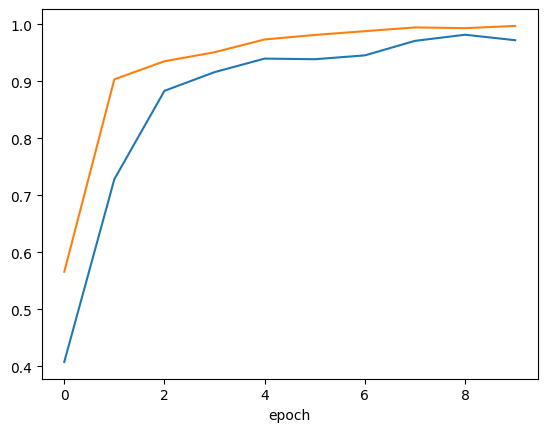

In [29]:
plt.plot(train_acc_list, label='train_acc')
plt.plot(test_acc_list, label='test_acc')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

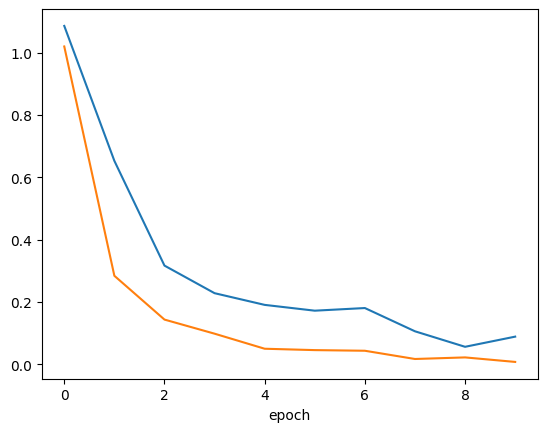

In [30]:
plt.plot(train_loss_list, label='train_loss')
plt.plot(test_loss_list, label='test_loss')
plt.xlabel('epoch')

## 4.2 Model Evaluation

In [31]:
best_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, label = torch.max(labels, 1)
        total += labels.size(0)
        correct += (predicted == label).sum().item()
    
    test_accuracy = correct / total

print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9974
